In [243]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed

import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs

# RNN

In [244]:
batchsize = 8
num_classes = 14
# specs
input_size = num_classes
output_size = 1
hidden_size = 20
num_layers = 1
learningRate = 0.005
epochs = 40

In [343]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()


def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(i):
    print('########## rep ', i, '##########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
    losses = loss1+loss2
    accs = np.vstack([acc1,acc2])
    return losses, accs

def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=8)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[4*j+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean().sort_values(by = 'acc', ascending=False)
                
    return df

# Data

In [151]:
pretrainpath = '../sequences/pretraining/'

with open(pretrainpath+'type2_3', 'rb') as f:
    type2_3 = pickle.load(f)
with open(pretrainpath+'type2_12', 'rb') as f:
    type2_12 = pickle.load(f)
with open(pretrainpath+'type2_48', 'rb') as f:
    type2_48 = pickle.load(f)

# Load Training and Test data
trianpath = '../sequences/training/'

#Mset
with open(trianpath + 'Mset', 'rb') as f:
    Mset = pickle.load(f)
with open(trianpath + 'Mtest_combos', 'rb') as f:
    Mtest_combos = pickle.load(f)
with open(trianpath + 'Mtest_order', 'rb') as f:
    Mtest_order = pickle.load(f)
with open(trianpath + 'Mtest_init', 'rb') as f:
    Mtest_init = pickle.load(f)

# MC set
with open(trianpath + 'MCset', 'rb') as f:
    MCset = pickle.load(f)
with open(trianpath + 'MCtest_order', 'rb') as f:
    MCtest_order = pickle.load(f)
with open(trianpath + 'MCtest_init', 'rb') as f:
    MCtest_init = pickle.load(f)
    
# DC set
with open(trianpath + 'DCset', 'rb') as f:
    DCset = pickle.load(f)
with open(trianpath + 'DCtest_order', 'rb') as f:
    DCtest_order = pickle.load(f)
with open(trianpath + 'DCtest_init', 'rb') as f:
    DCtest_init = pickle.load(f)

# F set
with open(trianpath + 'Fset', 'rb') as f:
    Fset = pickle.load(f)
with open(trianpath + 'Ftest_init', 'rb') as f:
    Ftest_init = pickle.load(f)

# Load Data

In [152]:
# convert sequences to inputs 
num_classes = 14

# Pretraining
train_inputs = convert_seq2inputs(type2_3, num_classes=num_classes, seq_len=8)
trainT2_3 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(type2_12, num_classes=num_classes, seq_len=8)
trainT2_12 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(type2_48, num_classes=num_classes, seq_len=8)
trainT2_48 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Mset
train_inputs = convert_seq2inputs(Mset, num_classes=num_classes, seq_len=8)
trainMset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mtest_combos, num_classes=num_classes, seq_len=8)
trainMtest_combos = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mtest_order, num_classes=num_classes, seq_len=8)
trainMtest_order = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mtest_init, num_classes=num_classes, seq_len=8)
trainMtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# MCaset
train_inputs = convert_seq2inputs(MCset, num_classes=num_classes, seq_len=8)
trainMCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCtest_order, num_classes=num_classes, seq_len=8)
trainMCtest_order = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCtest_init, num_classes=num_classes, seq_len=8)
trainMCtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# DCaset
train_inputs = convert_seq2inputs(DCset, num_classes=num_classes, seq_len=8)
trainDCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCtest_order, num_classes=num_classes, seq_len=8)
trainDCtest_order = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCtest_init, num_classes=num_classes, seq_len=8)
trainDCtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# Fset
train_inputs = convert_seq2inputs(Fset, num_classes=num_classes, seq_len=8)
trainFset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Ftest_init, num_classes=num_classes, seq_len=8)
trainFtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Run

Train T2_12 Exps:
1. MC set
2. DC set 
3. F set

Train T2_48 Exps:
1. MC set
2. DC set 
3. F set

In [348]:
learningRate = 0.005
epochs = 400

num_sims = 10
trainset = [trainT2_12, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_order = np.array([res[i][1][:,1] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,2] for i in range(len(res))]).T

time:  501.58292603492737


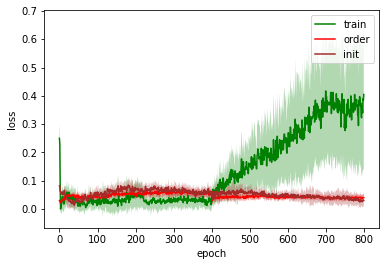

In [349]:
NNplt.plotNN_shifted([acc_train, acc_test_order, acc_test_init],\
                    labels = ['train',  'order','init'],\
                    colors = ['green', 'red','brown'],\
                    shift = 0)


In [116]:
len(DCset)

36

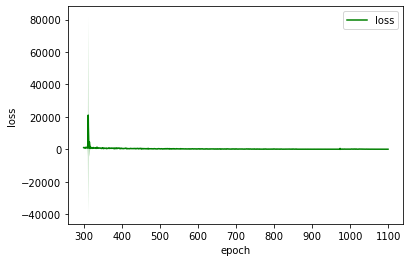

In [112]:
NNplt.plotNN_shifted([losses],
                    labels = ['loss'],\
                    colors = ['green'])

In [23]:
num_sims = 10
trainset = [trainT2_3, trainMset]
test_sets = [trainMset, trainMtest_combos, trainMtest_order, trainMtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_combos = np.array([res[i][1][:,1] for i in range(len(res))]).T
acc_test_order = np.array([res[i][1][:,2] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,3] for i in range(len(res))]).T

time:  175.72511386871338


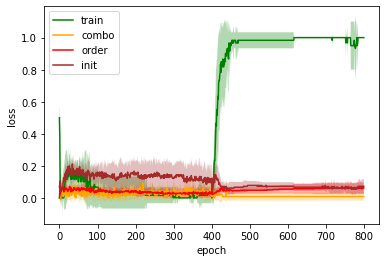

In [26]:
NNplt.plotNN_shifted([acc_train, acc_test_combos, acc_test_order, acc_test_init],\
                    labels = ['train', 'combo','order', 'init'],\
                    colors = ['green','orange', 'red', 'brown'],\
                    shift = 0)
# NNplt.plotNN_shifted([losses/(losses.max()*0.6)],\
#                     labels = ['loss'],\
#                     colors = ['blue'],\
#                     shift = 0)


In [27]:
num_sims = 10
trainset = [trainT2_12, trainMCset]
test_sets = [trainMCset, trainMCtest_order, trainMCtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_order = np.array([res[i][1][:,1] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,2] for i in range(len(res))]).T

time:  1369.9151117801666


IndexError: index 3 is out of bounds for axis 1 with size 3

In [28]:
losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_order = np.array([res[i][1][:,1] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,2] for i in range(len(res))]).T

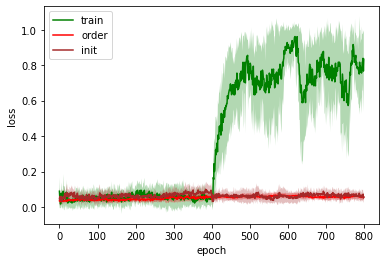

In [29]:
NNplt.plotNN_shifted([acc_train, acc_test_order, acc_test_init],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','red', 'brown'],\
                    shift = 0)


In [31]:
epochs = 100

In [32]:
num_sims = 10
trainset = [trainT2_12, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_order = np.array([res[i][1][:,1] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,2] for i in range(len(res))]).T

time:  346.18650698661804


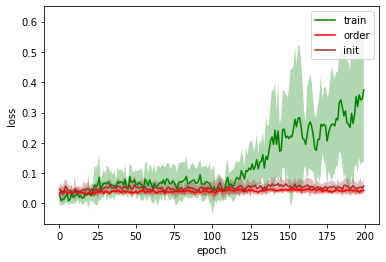

In [33]:
NNplt.plotNN_shifted([acc_train, acc_test_order, acc_test_init],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','red', 'brown'],\
                    shift = 0)


In [34]:
num_sims = 10
trainset = [trainT2_48, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_order = np.array([res[i][1][:,1] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,2] for i in range(len(res))]).T

time:  406.03929018974304


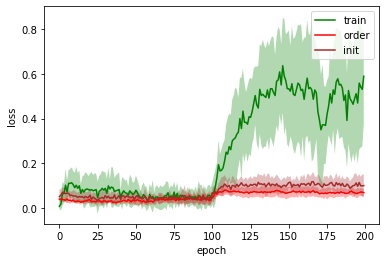

In [35]:
NNplt.plotNN_shifted([acc_train, acc_test_order, acc_test_init],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','red', 'brown'],\
                    shift = 0)


In [103]:
num_sims = 10
trainset = [trainT2_48, trainFset]
test_sets = [trainFset, trainFtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_order = np.array([res[i][1][:,1] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,2] for i in range(len(res))]).T

time:  751.742917060852


IndexError: index 2 is out of bounds for axis 1 with size 2

In [38]:
losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,1] for i in range(len(res))]).T

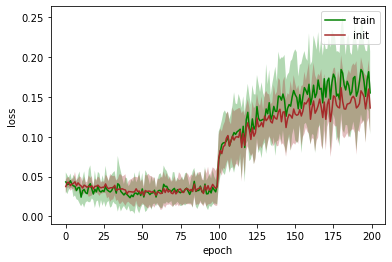

In [39]:
NNplt.plotNN_shifted([acc_train, acc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green','brown'],\
                    shift = 0)


In [40]:
num_sims = 10
trainset = [trainT2_12, trainFset]
test_sets = [trainFset, trainFtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

time:  1133.0823590755463


In [42]:
losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,1] for i in range(len(res))]).T

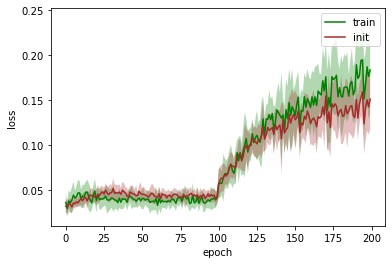

In [43]:
NNplt.plotNN_shifted([acc_train, acc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green','brown'],\
                    shift = 0)


In [44]:
from tqdm import tqdm

In [45]:
num_sims = 10
trainset = [trainT2_12, trainFset]
test_sets = [trainFset, trainFtest_init]
t1 = time.time()
res = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in tqdm(range(num_sims)))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

100%|██████████| 10/10 [00:00<00:00, 60.84it/s]


time:  2563.870244026184


In [46]:
losses = np.hstack([res[i][0] for i in range(len(res))])
acc_train = np.array([res[i][1][:,0] for i in range(len(res))]).T
acc_test_init = np.array([res[i][1][:,1] for i in range(len(res))]).T

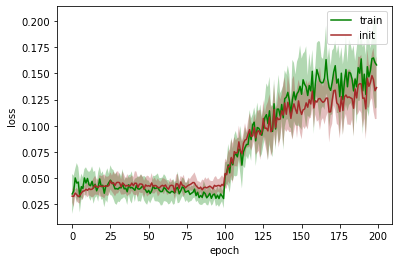

In [47]:
NNplt.plotNN_shifted([acc_train, acc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green','brown'],\
                    shift = 0)


In [350]:
df

,trial,acc
0,"['D', ('*', 'B'), ('*', 'B'), 63]",0.0
1,"['D', ('*', 'B'), ('*', 'B'), 63]",0.0
2,"['D', ('*', 'B'), ('*', 'B'), 63]",0.0
3,"['B', ('*', 'B'), ('*', 'A'), 18]",0.0
4,"['B', ('*', 'B'), ('*', 'A'), 18]",0.0
...,...,...
3955,"['C', ('*', 'D'), ('*', 'B'), 105]",0.0
3956,"['C', ('-', 'B'), ('+', 'C'), 7]",0.0
3957,"['C', ('-', 'B'), ('+', 'C'), 7]",0.0
3958,"['C', ('*', 'D'), ('*', 'B'), 105]",0.0


In [351]:
l = []

In [352]:
l.append(df)

In [353]:
l[0]

,trial,acc
0,"['D', ('*', 'B'), ('*', 'B'), 63]",0.0
1,"['D', ('*', 'B'), ('*', 'B'), 63]",0.0
2,"['D', ('*', 'B'), ('*', 'B'), 63]",0.0
3,"['B', ('*', 'B'), ('*', 'A'), 18]",0.0
4,"['B', ('*', 'B'), ('*', 'A'), 18]",0.0
...,...,...
3955,"['C', ('*', 'D'), ('*', 'B'), 105]",0.0
3956,"['C', ('-', 'B'), ('+', 'C'), 7]",0.0
3957,"['C', ('-', 'B'), ('+', 'C'), 7]",0.0
3958,"['C', ('*', 'D'), ('*', 'B'), 105]",0.0
